In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import DataFrame, Series 
from datetime import datetime
import isodate

In [2]:
api_key = ""
# api key deleted for security reasons
from apiclient.discovery import build

In [3]:
from apiclient.discovery import build

In [4]:
youtube = build('youtube','v3',developerKey=api_key)

# a. Data Collection using Youtube API

In [5]:
# Creating lists that hold the values of individual columns 

Columns=['Topic','Time Queried','Title','Video IDs','Published At','Duration','View Count','Like Count','Dislike Count']
VIDs=[]
Topic=[]
TimeQueried=[]
Title=[]
PublishedAt=[]
Duration=[]
ViewCount=[]
LikeCount=[]
DislikeCount=[]

### Using youtube search() api to search for a particular subject
### The maximum number of queries one  search can return is 50. If we want more queries, we must go to the nextpages to get the search results (which is done below)

In [6]:
AnalyticsrequestSearch = youtube.search().list(q='Microbiology',part='snippet',type='video',maxResults=50) 
# This creates an http request object which we must execute to finally get the data on the first page of the search results.

resultSearch = requestSearch.execute()

### Now, we go through the data stored in 'resultSearch' to get information on Topics, Video IDs, Titles and their Published Times

In [7]:
for i in (resultSearch['items']):
    VIDs.append(i['id']['videoId'])
    Title.append(i['snippet']['title'])
    PublishedAt.append(i['snippet']['publishedAt'])
    Topic.append('Microbiology')
    TimeQueried.append(datetime.now())
#print(PublishedAt)

# I now have Topics, VIDs, Titles, Published Times for the first 50 videos stored in the respective lists.

## Now, we use the youtube 'videos()' API to get the statistics (likes, dislikes, views) and Duration of video for the video IDs that we just saved above.


## Note/ Assumption: There are some videos for which the like/dislike count is hidden. So I'm instead putting '-1' in the place of like/dislike count as of now

In [8]:

requestVideos = youtube.videos().list(part=["statistics","contentDetails"],id=VIDs)
resultVideos = requestVideos.execute();
#print(result)

for i in resultVideos['items']:
    ViewCount.append(i['statistics']['viewCount'])
    if ('likeCount' in i['statistics']):
        LikeCount.append(i['statistics']['likeCount'])
        DislikeCount.append(i['statistics']['dislikeCount'])
    else:
        LikeCount.append(-1)
        DislikeCount.append(-1)
    Duration.append(i['contentDetails']['duration'])

In [9]:
# Using page token from the previous search 
# so that we can run loop for the next 10 pages
PageToken=resultSearch['nextPageToken']

### Now, after finding the nextPageToken from the previous 50 search results, I use it to increment the pages in a loop to get  500 more search results.

In [10]:
for i in range(10):
    requestSearch = youtube.search().list(q='Microbiology',part='snippet',type='video',maxResults=50,pageToken=PageToken) 
    resultSearch = requestSearch.execute()
    tempVID=[]
    for i in (resultSearch['items']):
        VIDs.append(i['id']['videoId'])
        Title.append(i['snippet']['title'])
        PublishedAt.append(i['snippet']['publishedAt'])
        Topic.append('Microbiology')
        TimeQueried.append(datetime.now())
        tempVID.append(i['id']['videoId'])
    
    # Now, to use another api to get the statistics(likes, dislikes, views) and Duration of video saved video IDs, 50 at a time    

    # We find the rest of the parameters of for the videos from the already found parameters
    requestVideos = youtube.videos().list(part=["statistics","contentDetails"],id=tempVID)
    resultVideos = requestVideos.execute();
    for i in resultVideos['items']:
        ViewCount.append(i['statistics']['viewCount'])
        if ('likeCount' in i['statistics']):
            LikeCount.append(i['statistics']['likeCount'])
            DislikeCount.append(i['statistics']['dislikeCount'])
        else:
            LikeCount.append(-1)
            DislikeCount.append(-1)
        Duration.append(i['contentDetails']['duration'])
    
    # incremental step of the loop
    PageToken=resultSearch['nextPageToken']

In [11]:
#creating a dataframe
Data={'Topic': Topic,
      'Time Queried':TimeQueried,
      'Title':Title,
      'Video IDs':VIDs,
      'Published At':PublishedAt,
      'Duration':Duration,
      'View Count':ViewCount,
      'Like Count':LikeCount,
      'Dislike Count':DislikeCount
     }
df=pd.DataFrame(Data, columns=Columns)


### We make a CSV file for the subject that we chose using the dataframe that we just created

In [12]:
df.to_csv('subject3.csv')

In [13]:
# We now have out data for our subject1 (Data structures) videos
# Now, to repeat the same for 2 more subjects

# Important note: I ran the above Data Collection part of the code 2 more times, replacing 'Data structures' with 'Economics' and then with 'Microbiology' & 'subject1.csv' with 'subject2.csv' and 'subject3.csv' respectively.
## Hence, I ended up with 3 different csv files: 'subject1.csv', 'subject2.csv' and 'subject3.csv' which I'll combine later on into one CSV fle along with the data of same search results at a different time.

## After running the same queries as above at a later time, I store their data in csv files: 'subject1_2.csv', 'subject2_2.csv' and 'subject3_2.csv'

---------------------

# b. Data cleaning/ filtering, manipulation

In [14]:
Columns=['Topic','Time Queried','Title','Video IDs','Published At','Duration','View Count','Like Count','Dislike Count']
# Reading the above created CSVs
df1=pd.read_csv('subject1.csv',usecols=Columns)
df2=pd.read_csv('subject2.csv',usecols=Columns)
df3=pd.read_csv('subject3.csv',usecols=Columns)

df1_2=pd.read_csv('subject1_2.csv',usecols=Columns)
df2_2=pd.read_csv('subject2_2.csv',usecols=Columns)
df3_2=pd.read_csv('subject3_2.csv',usecols=Columns)

# Making the combined CSV file
dftemp=df1
dftemp=dftemp.append([df2,df3,df1_2,df2_2,df3_2])
dftemp.to_csv('11840220_data.csv')

## Removing the duplicate values from the dataframes

In [15]:
df1.drop_duplicates(subset=['Video IDs'], keep=False, inplace=True)
df1_2.drop_duplicates(subset=['Video IDs'], keep=False, inplace=True)

df2.drop_duplicates(subset=['Video IDs'], keep=False, inplace=True)
df2_2.drop_duplicates(subset=['Video IDs'], keep=False, inplace=True)

df3.drop_duplicates(subset=['Video IDs'], keep=False, inplace=True)
df3_2.drop_duplicates(subset=['Video IDs'], keep=False, inplace=True)

## Function to drop the rows that have like/dislike count -1, i.e., hidden like/dislike count
 (I had inserted -1 above Likes/Dislikes of videos whose Likes/Dislikes count were hidden in the previous steps)

In [16]:
def dropNegatives(df_common):
    df_common = df_common[df_common['Like Count'] != -1]
    
    return df_common

## Function for formatting the time Durations to show in hours.

In [17]:
#
def toTime(df):
    durationH=[]
    durn=df['Duration']
    for i in durn:
        durn=isodate.parse_duration(i)
        x=durn.total_seconds()/3600
        x=round(x,3)
        durationH.append(x)
    return durationH
def convertTimer(df):
    df["Duration"]=toTime(df)
    return df
            

## Function for adding z- scores for numerical columns of the dataframes

In [18]:
# Z score
def z_adder(df):
    cols = ['Duration','View Count','Like Count','Dislike Count','View delta','Like delta','Dislike delta']
       

    # now iterate over the remaining columns and create a new zscore column
    for col in cols:
        col_zscore = col + '_zscore'
        df[col_zscore] = (df[col] - df[col].mean())/df[col].std(ddof=1)
    return df
    

# Scoring Function

## According to me:-
### 1. The more the number of Views on the video the more preferrable it would be.
### 2. The more the number of Likes and increase in likes on the video, the more preferrable it would be.
### 3. The less the number of Dislikes and the increase in dislikes on the video, the more preferrable it would be.
### 4. The more the number of Likes on the video the more preferrable it would be.
### 5. The shorter the Duration of the video, the more preferrable it would be 

### my suggested Scoring function :
    

In [19]:
# Scoring Function
def Score(df):
    cols = ['Duration_zscore','View Count_zscore','Like Count_zscore','Dislike Count_zscore','View delta_zscore','Like delta_zscore','Dislike delta_zscore']
    
    col_score = 'Score'
    df[col_score] = df['View Count_zscore']*( 1 + df['View delta_zscore']) + df['Like Count_zscore'] - df['Dislike Count_zscore'] + df['Like delta_zscore'] - df['Dislike delta_zscore'] - df['Duration_zscore']*0.7 
   
    return df
    

## Function for finding the common videos between the datasets(day 1 and day 2) of the same subject and applying the cleaning/formatting and Scoring functions

In [20]:
# finds the common videos between the datasets of the same subject (but queried at different times)
def create_Dataframe(Df1, Df2):
    # cols=Df1.columns.tolist()
    Columns=['Topic','Time Queried','Title','Video IDs','Published At','Duration','View Count','Like Count','Dislike Count','View delta','Like delta','Dislike delta']
    df_common = pd.DataFrame(columns = Columns)
    i=0
    for index, row in Df1.iterrows(): 
    
        # extract the row from Df2 which is also present in Df1
        values =  (Df2.loc[Df2['Video IDs'] == row['Video IDs']])
        # print (row["Video IDs"])
        
        # check whether it is empty or not
        if(values.empty == False):
            templist = row
            templist['View delta']=0
            templist['Like delta']=0
            templist['Dislike delta']=0
            if(values.shape[0]>1):
                templist['View delta']=float(values[0]['View Count']) - float(row['View Count'])
                templist['Like delta']=float(values[0]['Like Count']) - float(row['Like Count'])
                templist['Dislike delta']=float(values[0]['Dislike Count']) - float(row['Dislike Count'])
            else:
                templist['View delta']=float(values['View Count']) - float(row['View Count'])
                templist['Like delta']=float(values['Like Count']) - float(row['Like Count'])
                templist['Dislike delta']=float(values['Dislike Count']) - float(row['Dislike Count'])
            df_common=df_common.append(templist)
    
    # Drop rows with hidden likes/columns
    df_common=dropNegatives( df_common)
    
    # Convert Duration in 'Hours'
    df_common=convertTimer(df_common)
    
    # Add z-scores
    df_common=z_adder(df_common)
    
    # Add Scores using the Scoring Function
    df_common=Score(df_common)
    return df_common

  ## We now create cleaned/formatted individual data frames along with Scores for the 3 subjects using the above Functions

In [21]:
dfSubject1= create_Dataframe(df1,df1_2)
dfSubject2= create_Dataframe(df2,df2_2)
dfSubject3= create_Dataframe(df3,df3_2)


----------------

# c. Data Analysis (rankings, visualization)

## Ranking videos based on higher 'Score'
## Below are ranked dataframes - Top of the data frame is ranked highest

## Ranking of subject 1 videos 
### Dataframe of subject 1 sorted in decending order of 'Score'

In [22]:
dfSubject1.sort_values(by=['Score'],ascending=False)

,Topic,Time Queried,Title,Video IDs,Published At,Duration,View Count,Like Count,Dislike Count,View delta,Like delta,Dislike delta,Duration_zscore,View Count_zscore,Like Count_zscore,Dislike Count_zscore,View delta_zscore,Like delta_zscore,Dislike delta_zscore,Score
1,Data Structures,2020-08-20 16:23:24.606594,Data Structures Easy to Advanced Course - Full...,RBSGKlAvoiM,2019-09-19T14:39:38Z,8.055,1544143,39428,377,6759.0,166.0,1.0,9.032237,5.4421,9.27063,3.8255,10.606374,6.715111,1.466878,67.5339
28,Data Structures,2020-08-20 16:23:24.606947,The Placement Course : Java + Data Structures ...,lxja8wBwN0k,2019-07-11T12:52:24Z,0.574,859734,27537,301,5099.0,141.0,2.0,0.139438,2.81756,6.33071,2.94121,7.886161,5.650962,3.168649,30.8115
410,Data Structures,2020-08-20 16:23:35.652205,Introduction to data structures,92S4zgXN17o,2013-03-25T23:48:32Z,0.109,2300536,11475,195,1515.0,19.0,0.0,-0.413316,8.34268,2.35957,1.70785,2.013124,0.457914,-0.234892,26.7714
2,Data Structures,2020-08-20 16:23:24.606606,Data Structures &amp; Algorithms #1 - What Are...,bum_19loj9A,2018-03-12T05:19:30Z,0.276,1204121,23441,387,2004.0,59.0,2.0,-0.214800,4.1382,5.31802,3.94186,2.814439,2.160553,3.168649,16.3033
175,Data Structures,2020-08-20 16:23:28.718716,Introduction to Data Structures through C | Da...,Db9ZYbJONHc,2016-09-23T21:21:23Z,0.261,935940,8707,229,1541.0,31.0,0.0,-0.232630,3.10979,1.67521,2.10346,2.055729,0.968705,-0.234892,10.4409
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,Data Structures,2020-08-20 16:23:28.718753,How Long It Took Me To Master Data Structures ...,6bfXvaUl98g,2020-08-09T06:00:13Z,0.229,63152,3862,86,1079.0,44.0,3.0,-0.270669,-0.237136,0.477338,0.43959,1.298658,1.522063,4.870419,-3.66623
197,Data Structures,2020-08-20 16:23:28.718775,Data Structures and Algorithms Complete Tutori...,YWnBbNj_G-U,2016-03-16T07:34:00Z,6.823,806066,10094,283,209.0,3.0,0.0,7.567737,2.61176,2.01813,2.73177,-0.126996,-0.223142,-0.234892,-3.71923
6,Data Structures,2020-08-20 16:23:24.606653,DS ALGO v/s Competitive Programming | How to S...,IiAL14tIkZY,2020-08-19T06:30:14Z,0.194,9680,1063,27,4532.0,296.0,8.0,-0.312275,-0.442188,-0.214683,-0.246901,6.957028,12.248687,13.379271,-4.39828
62,Data Structures,2020-08-20 16:23:25.842286,Data Structures and Algorithms - Advanced Java...,n0GjRXs0jTk,2020-02-03T12:59:40Z,5.938,18592,658,9,213.0,8.0,0.0,6.515722,-0.408013,-0.314814,-0.456339,-0.120441,-0.010312,-0.234892,-4.55377


## Ranking of subject 2 videos 
### Dataframe of subject 2 sorted in decending order of 'Score'

In [23]:
dfSubject2.sort_values(by=['Score'],ascending=False)

,Topic,Time Queried,Title,Video IDs,Published At,Duration,View Count,Like Count,Dislike Count,View delta,Like delta,Dislike delta,Duration_zscore,View Count_zscore,Like Count_zscore,Dislike Count_zscore,View delta_zscore,Like delta_zscore,Dislike delta_zscore,Score
162,Economics,2020-08-20 16:35:45.587784,Paul Krugman Teaches Economics and Society | O...,JRhvnlQHKc0,2018-11-15T07:48:18Z,0.029,27507324,1952,563,17339.0,1.0,0.0,-0.356211,12.7467,-0.341708,-0.0436463,4.620729,-0.347329,-0.232480,71.4822
19,Economics,2020-08-20 16:35:40.455205,How The Economic Machine Works by Ray Dalio,PHe0bXAIuk0,2013-09-22T18:07:47Z,0.517,18487594,308477,8502,15245.0,257.0,15.0,0.118922,8.46822,12.7327,5.48693,4.009917,1.945371,1.004234,50.5287
287,Economics,2020-08-20 16:35:49.075570,INCREÍBLE! THE ECONOMIST OTRA VEZ - GRAN TORME...,4aHL-iFOU5o,2020-08-19T16:29:16Z,0.079,52935,7586,70,14727.0,1427.0,28.0,-0.307529,-0.276205,-0.101397,-0.387087,3.858818,12.423728,2.076052,9.5066
48,Economics,2020-08-20 16:35:40.455257,Intro to Economics: Crash Course Econ #1,3ez10ADR_gM,2015-07-08T22:34:19Z,0.203,4869122,62956,2707,6391.0,93.0,7.0,-0.186799,2.00834,2.26034,1.44994,1.427239,0.476610,0.344653,5.94783
37,Economics,2020-08-20 16:35:40.455237,Elon Musk&#39;s Basic Economics,h97fXhDN5qE,2017-10-24T14:30:00Z,0.173,5328562,122903,3508,2079.0,49.0,0.0,-0.216008,2.22627,4.81729,2.00794,0.169446,0.082552,-0.232480,5.87909
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,Economics,2020-08-20 16:35:40.455163,🔴Economics Non Stop by Afreen Ma&#39;am (Time...,9oILKKRO82s,2020-05-06T12:30:13Z,11.917,632176,33837,1017,5411.0,314.0,7.0,11.218347,-0.00144416,1.0183,0.272626,1.141377,2.455855,0.344653,-4.99906
107,Economics,2020-08-20 16:35:43.856348,Basic Economics - Thomas Sowell Audible Audio ...,dQiBD-crrvA,2016-01-24T11:13:45Z,9.395,541830,8893,314,1533.0,33.0,3.0,8.762843,-0.0442995,-0.0456488,-0.217108,0.010180,-0.060741,0.014863,-6.08289
425,Economics,2020-08-20 16:35:53.962549,Fantasy cartography: Redrawing the map of Euro...,xdReh4le7x0,2010-05-24T08:22:18Z,0.057,2649497,20082,11663,1799.0,45.0,10.0,-0.328949,0.955466,0.431603,7.68899,0.087771,0.046729,0.591996,-6.53306
295,Economics,2020-08-20 16:35:49.075614,Election 2020: what a Biden victory could mean...,9UdZzFVC6XU,2020-08-07T15:00:03Z,0.168,869653,15568,6835,9622.0,139.0,102.0,-0.220876,0.111202,0.239064,4.32564,2.369710,0.888580,8.177172,-10.8458


## Ranking of subject 3 videos 
### Dataframe of subject 3 sorted in decending order of 'Score'

In [24]:
dfSubject3.sort_values(by=['Score'],ascending=False)

,Topic,Time Queried,Title,Video IDs,Published At,Duration,View Count,Like Count,Dislike Count,View delta,Like delta,Dislike delta,Duration_zscore,View Count_zscore,Like Count_zscore,Dislike Count_zscore,View delta_zscore,Like delta_zscore,Dislike delta_zscore,Score
2,Microbiology,2020-08-20 16:53:27.916787,Introduction To Microbiology,fU0XO1X1tAE,2017-09-26T20:34:26Z,0.113,475946,9680,205,955.0,38.0,0.0,-0.466758,5.26441,8.41286,5.33691,8.293449,8.937081,-0.252908,61.5172
251,Microbiology,2020-08-20 16:53:35.729834,Aseptic Technique,bRadiLXkqoU,2012-10-16T19:26:25Z,0.100,459898,2333,61,545.0,6.0,0.0,-0.502875,5.07142,1.633,1.215,4.458087,0.990927,-0.252908,29.6941
210,Microbiology,2020-08-20 16:53:34.195760,Microbiology - Antibiotics Mechanisms of Action,IVBCrzjOl40,2013-12-16T23:28:59Z,0.121,565837,6937,99,244.0,5.0,0.0,-0.444533,6.34542,5.8816,2.30273,1.642369,0.742609,-0.252908,21.6525
38,Microbiology,2020-08-20 16:53:27.916853,Chapter 1 Introduction to Microbiology,pUa7pWhHyrM,2016-01-11T17:00:09Z,0.877,452645,5169,162,386.0,11.0,0.0,1.655802,4.9842,4.25008,4.10606,2.970714,2.232513,-0.252908,21.2612
265,Microbiology,2020-08-20 16:53:35.729921,Salmonella - SketchyMicro (USMLE Step 1 Microb...,EiKg08WoKPM,2013-01-10T07:24:49Z,0.132,353446,3580,72,340.0,13.0,0.0,-0.413972,3.79126,2.78374,1.52987,2.540405,2.729148,-0.252908,17.9483
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
217,Microbiology,2020-08-20 16:53:34.195811,General knowledge on microbiology,LFPtVb3HRJo,2017-05-12T14:27:55Z,0.181,21324,288,33,21.0,1.0,1.0,-0.277839,-0.202758,-0.254143,0.413523,-0.443694,-0.250660,3.576839,-4.41347
453,Microbiology,2020-08-20 16:53:41.327955,Chapter 1 APURBA SASTRY GENERAL MICROBIOLOGY,lj4mzfmx2As,2019-05-08T09:44:04Z,2.711,17747,271,8,86.0,3.0,0.0,6.751058,-0.245774,-0.269831,-0.302086,0.164352,0.245975,-0.252908,-4.48077
103,Microbiology,2020-08-20 16:53:30.976896,Microbiology AIIMS 2020 Recall session (We are...,3fsOqBlyED0,2020-07-30T11:30:12Z,1.196,12516,393,8,150.0,4.0,1.0,2.542054,-0.308681,-0.157249,-0.302086,0.763042,0.494292,3.576839,-5.26136
346,Microbiology,2020-08-20 16:53:37.171922,Biology 2019 Theory - Damitha Pinnagoda - Spec...,puRdDsEG9w4,2019-07-15T03:22:15Z,1.860,25995,340,7,60.0,1.0,1.0,4.386792,-0.146586,-0.206157,-0.33071,-0.078866,-0.250660,3.576839,-6.90873


# Visualization Through Graphs 

In [25]:
# function to plot subgraphs
def plotGraph(df):
    cols=['Preference','Views','Likes','Duration','Delta Likes']
    temp=pd.DataFrame(columns = cols)
    temp['Preference']=(df['Score'] - df['Score'].mean())/df['Score'].std(ddof=1)
    temp['Views']=df['View Count_zscore']
    temp['Likes']=df['Like Count_zscore']
    temp['Duration']=df['Duration_zscore']
    temp['Duration']=df['Duration_zscore']
    temp['Delta Likes']=df['Like delta_zscore']
    
    fig,a =  plt.subplots(2,2,figsize=(15,15),squeeze=False)
    
    a[0][0].scatter(temp['Views'],temp['Preference'])
    a[0][0].set_title('Preference vs Views')
    a[0][0].set_ylabel('Preference')
    a[0][0].set_xlabel('Views')
    
    a[0][1].scatter(temp['Likes'],temp['Preference'])
    a[0][1].set_title('Preference vs Likes')
    a[0][1].set_ylabel('Preference')
    a[0][1].set_xlabel('Likes')
    
    a[1][0].scatter(temp['Duration'],temp['Preference'])
    a[1][0].set_title('Preference vs Duration')
    a[1][0].set_ylabel('Preference')
    a[1][0].set_xlabel('Duration')
    
    a[1][1].scatter(temp['Delta Likes'],temp['Preference'])
    a[1][1].set_title('Preference vs Delta Likes')
    a[1][1].set_ylabel('Preference')
    a[1][1].set_xlabel('Delta Likes')
    
    a[0][0].grid()
    a[1][0].grid()
    a[0][1].grid()
    a[1][1].grid()
    
    plt.show()
  
    
    

# Important Obeservations: 
## Notice that all the plots below, except for Preference vs Duration grow linearly
## Preference vs Duration is hyperbolic in shape 
#### Note: The scales are normalized and I've shown only 4 factors affecting the preference of choosing a video in the playlist in the below graphs ( there are others as well - as defined in our scoring function)

## Plots for Subject 1 

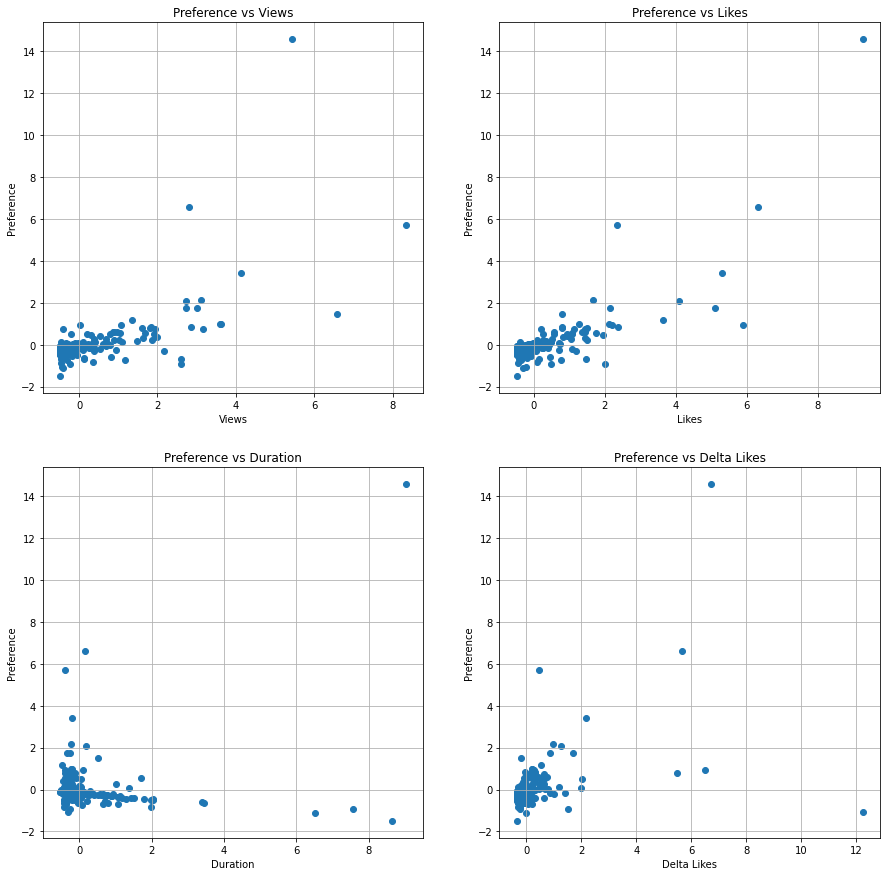

In [26]:
# plots for subject 1
plotGraph(dfSubject1)

## Plots for Subject 2

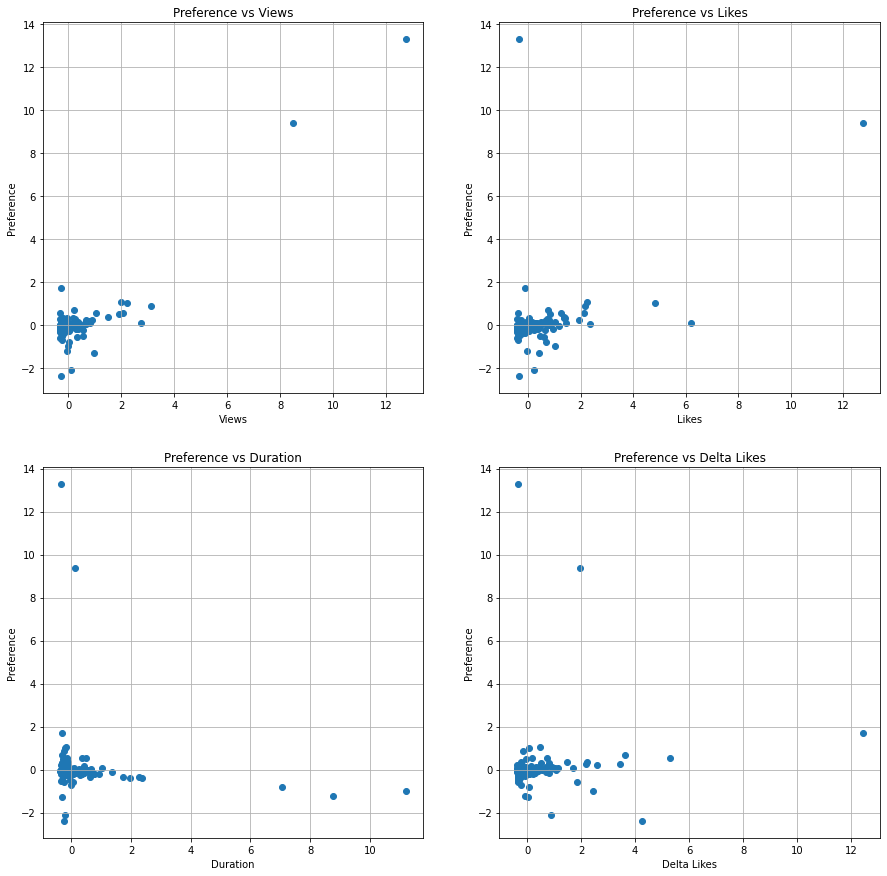

In [27]:
# plots for subject 2
plotGraph(dfSubject2)

## Plots for Subject 3

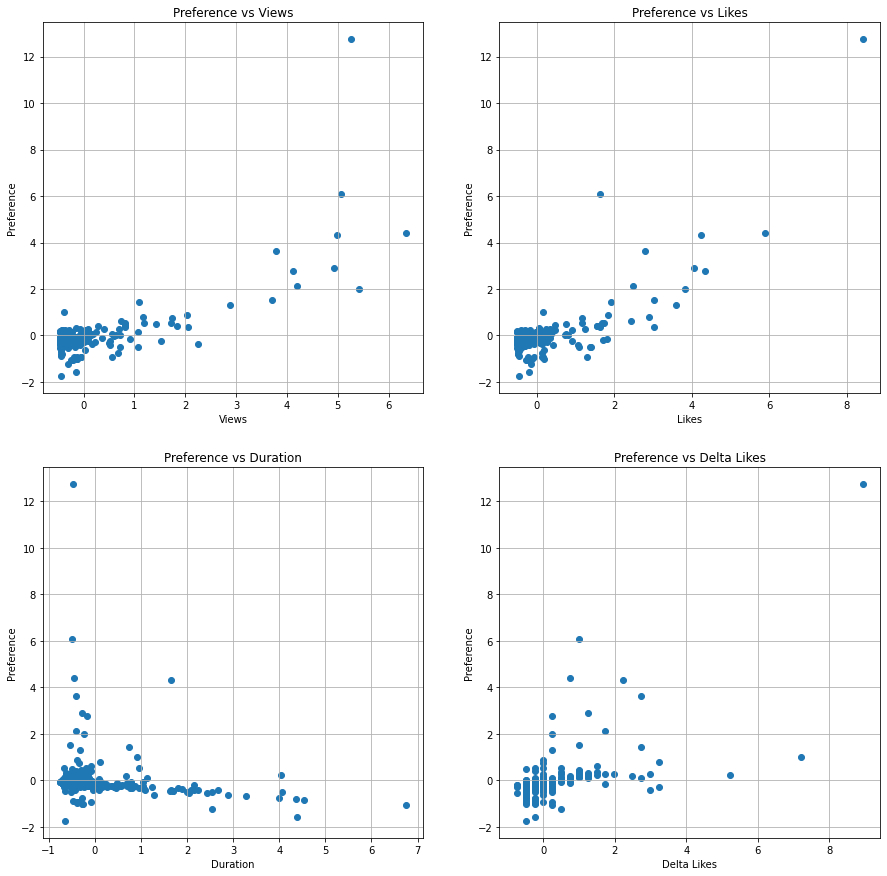

In [28]:
# plots for subject 3
plotGraph(dfSubject3)

# Conclusion from graphs
## All the plots other than Preference vs Duration grow linearly since Views, Likes and delta Likes were directly proportional to the Score (according to our scoring function)
## Preference vs Duration is hyperbolic in shape because Duration of video was inversely proportional to the Score (according to our scoring function)

# d. Playlist Creation Algorithm


## We want the top 'x' videos such that the summation of their durations is <= 10 hours.
### Approach:
1. Sort the videos according to Decending order of their 'Score'. The first video is the one with the highest score and the last one, with the lowest score.
2. Start accepting videos into the playlist (starting from the highest score video) if and only if after adding it into the playlist, the playlist's time <= 15
3. Stop if total duration of playlist becomes exactly 15 or if we reach the last video of the sorted list of videos


In [29]:
def createPlaylist(df):
    # Sorting in descending order of scores
    df=df.sort_values(by=['Score'],ascending=False)
    
    # uncomment below to see the descending order data frame
    # print(df)
    timeleft=10
    playlist=[[]]
    i=0
    j=0
    for index, video in df.iterrows():
        if(video['Duration']<=timeleft):
            playlist.append(video)
            timeleft=timeleft-video['Duration']
            # print(video)
        i=i+1
    temp=pd.DataFrame(playlist, columns=df.columns)
    temp=temp[temp.index != 0]
    temp.drop(temp.columns[[1,3,4,6,7,8,9,10,11,12,13,14,15,16,17,18,19]], axis = 1,inplace=True) 
  
    return temp
     

In [30]:
playlist1=createPlaylist(dfSubject1)
playlist2=createPlaylist(dfSubject2)
playlist3=createPlaylist(dfSubject3)

## Play Lists with topic, title and duration of video in hours

### Play List for Subject 1 - Data Structures

In [31]:
playlist1

,Topic,Title,Duration
1,Data Structures,Data Structures Easy to Advanced Course - Full...,8.055
2,Data Structures,The Placement Course : Java + Data Structures ...,0.574
3,Data Structures,Introduction to data structures,0.109
4,Data Structures,Data Structures &amp; Algorithms #1 - What Are...,0.276
5,Data Structures,Introduction to Data Structures through C | Da...,0.261
6,Data Structures,Introduction to Big O Notation and Time Comple...,0.606
7,Data Structures,Resources for Learning Data Structures and Alg...,0.060
8,Data Structures,Data Structure - Getting Started,0.018
9,Data Structures,Print Decreasing Increasing - Question | Recur...,0.021
10,Data Structures,Diagonal Traversal - Question | 2-D Arrays | D...,0.014


### Play List for Subject 2 - Economics

In [32]:
playlist2

,Topic,Title,Duration
1,Economics,Paul Krugman Teaches Economics and Society | O...,0.029
2,Economics,How The Economic Machine Works by Ray Dalio,0.517
3,Economics,INCREÍBLE! THE ECONOMIST OTRA VEZ - GRAN TORME...,0.079
4,Economics,Intro to Economics: Crash Course Econ #1,0.203
5,Economics,Elon Musk&#39;s Basic Economics,0.173
6,Economics,Fear the Boom and Bust: Keynes vs. Hayek - The...,0.126
7,Economics,Japan begins the undoing of China’s economic m...,0.087
8,Economics,आर्थिकी 2020 || Latest Economic Data of INDIA ...,0.771
9,Economics,Thomas Sowell on the Myths of Economic Inequality,0.893
10,Economics,The deep ocean is the final frontier on planet...,0.247


### Play List for Subject 3 - Microbiology

In [33]:
playlist3

,Topic,Title,Duration
1,Microbiology,Introduction To Microbiology,0.113
2,Microbiology,Aseptic Technique,0.100
3,Microbiology,Microbiology - Antibiotics Mechanisms of Action,0.121
4,Microbiology,Chapter 1 Introduction to Microbiology,0.877
5,Microbiology,Salmonella - SketchyMicro (USMLE Step 1 Microb...,0.132
6,Microbiology,"Microbiology - Bacteria Growth, Reproduction, ...",0.178
7,Microbiology,Microbiology - Bacteria Antibiotic Resistance,0.217
8,Microbiology,A tour of the Microbiology Lab - Section one,0.137
9,Microbiology,Microbiology - Overview,0.197
10,Microbiology,"CAREERS IN B.Sc MICROBIOLOGY - M.Sc,DEGREE,Job...",0.090
